In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from procyon.data.data_utils import DATA_DIR

In this notebook, we recreate the results from Extended Data Figure 8. We show how phenotype generations can be combined with QA filtering scores, and how the average quality of phenotype generations increases as the stringency of the QA filtering threshold increases.

To demonstrate this, we directly load the cached results from our experiments, which are stored in the [ProCyon-Instruct dataset](https://huggingface.co/datasets/mims-harvard/ProCyon-Instruct). These results contain two files per dataset, the original phenotype generations as
produced via the [evaluation framework](https://github.com/mims-harvard/ProCyon/tree/main/procyon/evaluate) and the QA filtering scores as
generated by the [`qa_filter.py`](https://github.com/mims-harvard/ProCyon/blob/main/scripts/qa_filter_captions.py) script.

In [2]:
procyon_color = "#9467BD"

In [3]:
mol_func_name = "Function"
path_name = "Pathway"
dis_name = "Disease"

domain_order = [
    mol_func_name,
    path_name,
    dis_name,
]

kd_map = {
    "protein_uniprot_all": mol_func_name,
    "protein_reactome_all": path_name,
    "protein_disgenet_all": dis_name,

}

In [4]:
base_path = os.path.join(
    DATA_DIR,
    "experimental_data",
    "extended_data",
    "bertscore_by_qa_filter",
)

dataset_paths = [f for f in os.listdir(base_path) if not "drugbank" in f]
dataset_paths

['protein_disgenet_all', 'protein_uniprot_all', 'protein_reactome_all']

In [5]:
def cumulative_bin(
    df: pd.DataFrame,
    col: str="yes_binned",
    min_keep: int = 0,
) -> pd.DataFrame:
    """Duplicate rows in dataframe such that each row appears for every threshold it exceeds."""
    duped = []
    for thresh in df[col].unique():
        for _, sub_df in df.groupby("seq_id"):
            sub_df = sub_df.sort_values(col, ascending=False)
            above_thresh = sub_df[col] >= thresh
            if above_thresh.sum() < min_keep:
                keep = sub_df.head(n=min_keep)
            else:
                keep = sub_df.loc[above_thresh]

            if len(keep) != 0:
                keep[col] = thresh
                duped.append(keep)
    return pd.concat(duped)

def get_scored_captions(
    dataset: str,
) -> pd.DataFrame:
    """Read original phenotype generations and merge with QA filtering scores."""
    dataset_dir = os.path.join(base_path, dataset)
    filt_path = [f for f in os.listdir(dataset_dir) if f.endswith(".csv")][0]
    with open(os.path.join(dataset_dir, "full_captions.tsv.gz"), "rb") as fh:
        full = pd.read_table(fh, compression="gzip")
    with open(os.path.join(dataset_dir, filt_path)) as fh:
        filt = pd.read_csv(fh)

    filt = (
        full
        .rename_axis(index="ref_index")
        .reset_index()
        .merge(filt[["ref_index", "yes", "no"]], on="ref_index")
    )
    return filt

def prep_dataset(
    path: str,
    metric: str = "bertscore_f1",
) -> pd.DataFrame:
    """Load QA filtered phenotype generations"""
    scored_captions = (
        get_scored_captions(path)
        .groupby(["seq_id", "generated_caption"])
        [["yes", metric]]
        .max()
        .reset_index()
        .drop(columns="generated_caption")
        [["seq_id", metric, "yes"]]
        .assign(
            yes_binned=lambda x: pd.cut(x.yes, bins=np.linspace(0, 1, 11)),
        )
    )
    return scored_captions

In [6]:
all_scored_captions = []
for path in dataset_paths:
    scored = prep_dataset(path)
    all_scored_captions.append(
        cumulative_bin(scored, col="yes_binned", min_keep=1).assign(dataset=path)
    )

all_scored_captions = (
    pd.concat(all_scored_captions)
    .assign(
        knowledge_domain=lambda x: x.dataset.map(kd_map),
    )
)
all_scored_captions.head()

/tmp/ipykernel_2810030/1864115442.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keep[col] = thresh
/tmp/ipykernel_2810030/1864115442.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keep[col] = thresh
/tmp/ipykernel_2810030/1864115442.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

,seq_id,bertscore_f1,yes,yes_binned,dataset,knowledge_domain
0,306,0.123756,0.506281,"(0.5, 0.6]",protein_disgenet_all,Disease
5,424,-0.019323,0.581429,"(0.5, 0.6]",protein_disgenet_all,Disease
12,648,0.104202,0.454882,"(0.5, 0.6]",protein_disgenet_all,Disease
15,1199,-0.432601,0.787758,"(0.5, 0.6]",protein_disgenet_all,Disease
17,1199,0.138061,0.718945,"(0.5, 0.6]",protein_disgenet_all,Disease


Text(0.5, 1.0, 'knowledge_domain = Function')
Text(0.5, 1.0, 'knowledge_domain = Pathway')
Text(0.5, 1.0, 'knowledge_domain = Disease')


/tmp/ipykernel_2810030/2336735912.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/ipykernel_2810030/2336735912.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)
/tmp/ipykernel_2810030/2336735912.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


<Figure size 1000x1000 with 0 Axes>

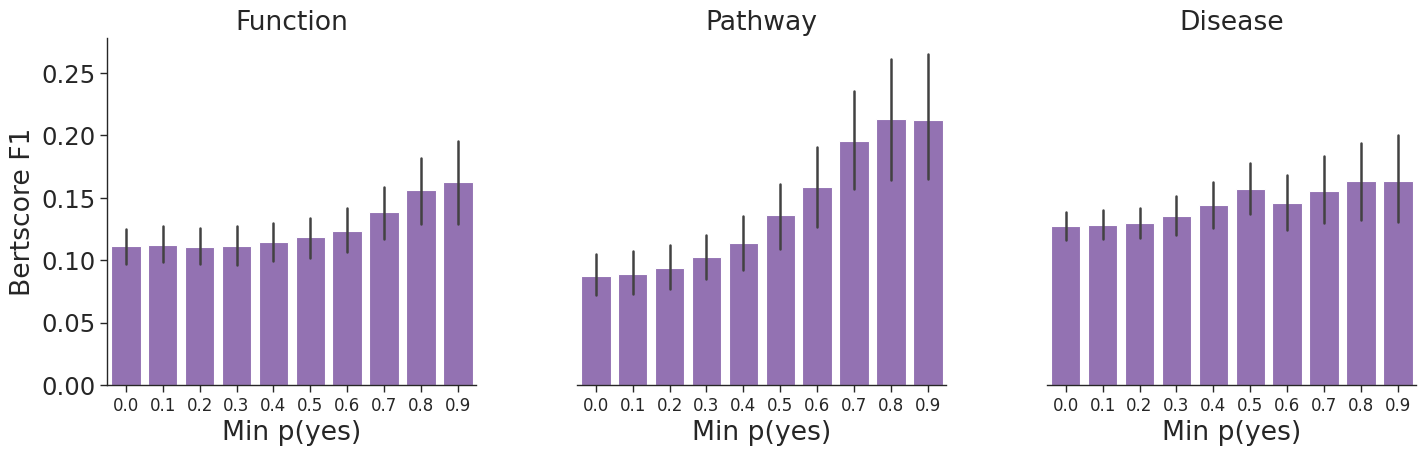

In [7]:
order = all_scored_captions.yes_binned.drop_duplicates().sort_values().astype(str).to_list()

plot_data = (
    all_scored_captions
    .astype({"yes_binned": str})
)

sns.set_theme(context="paper", style="ticks", font_scale=2,)

plt.figure(figsize=(10, 10))

fg = sns.FacetGrid(
    col="knowledge_domain",
    col_order=domain_order,
    data=plot_data,
    height=5,
    aspect=1,
)
fg.map_dataframe(sns.barplot, x="yes_binned", y="bertscore_f1", order=order, color=procyon_color)

sns.despine()
fg.despine()


for row in fg.axes:
    for i, ax in enumerate(row):
        print(ax.title)
        curr_title = ax.title.get_text()
        kd = curr_title.replace("knowledge_domain = ", "")
        ax.set_title(kd)
        ax.set_xlabel("Min p(yes)")

        labels = ax.get_xticklabels()
        labels = [l.get_text().split(",")[0].strip("(") for l in labels]
        ax.set_xticklabels(labels)
        ax.tick_params(axis='x', which='major', labelsize=12)

        if i != 0:
            ax.yaxis.set_visible(False)
            ax.spines["left"].set_visible(False)
        else:
            ax.set_ylabel("Bertscore F1")